In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Example: Informative positions and observed reads
informative_positions = [101, 204, 309]  # Example variant positions
observed_reads = np.array([5, 3, 2])     # B-allele reads per position
total_reads = np.array([500, 400, 300])  # Total reads at each position
error_rate = 0.01                        # Sequencing error rate

In [3]:

# Function to compute binomial likelihood for a single position
def binomial_likelihood(p, k, n, eps):
    expected_freq = p * (1 - eps) + (1 - p) * eps
    return stats.binom.pmf(k, n, expected_freq)

# Compute overall likelihood for all positions
def compute_likelihood(p, observed_reads, total_reads, eps):
    likelihoods = [
        binomial_likelihood(p, k, n, eps) 
        for k, n in zip(observed_reads, total_reads)
    ]
    return np.prod(likelihoods)

# Define a uniform prior for the mixture proportion p (0 to 5%)
def prior(p):
    return 1 if 0 <= p <= 0.05 else 0

# Posterior distribution function (unnormalized)
def posterior(p, observed_reads, total_reads, eps):
    return compute_likelihood(p, observed_reads, total_reads, eps) * prior(p)

plt.show()


In [4]:
# Discretize the parameter space for visualization
p_values = np.linspace(0, 0.05, 500)
posterior_values = [posterior(p, observed_reads, total_reads, error_rate) for p in p_values]

# Normalize the posterior to integrate to 1
posterior_values /= np.sum(posterior_values)




Text(0.5, 1.0, 'Posterior Distribution of Mixture Proportion')

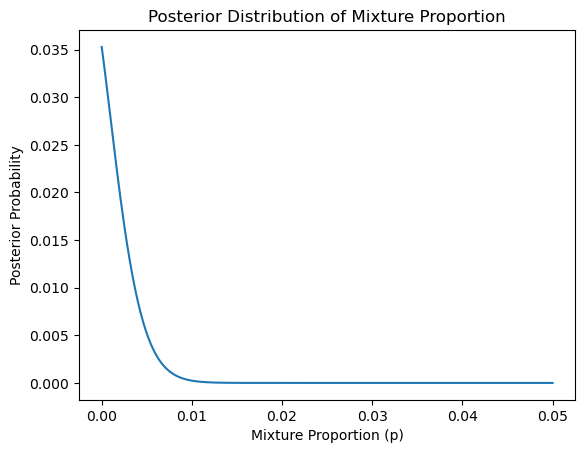

In [5]:
# Plot the posterior distribution
plt.plot(p_values, posterior_values)
plt.xlabel("Mixture Proportion (p)")
plt.ylabel("Posterior Probability")
plt.title("Posterior Distribution of Mixture Proportion")

In [6]:
# Function to simulate reads for a given mixture ratio
def simulate_reads(p_true, total_reads, eps):
    simulated_reads = []
    for n in total_reads:
        expected_freq = p_true * (1 - eps) + (1 - p_true) * eps
        k = np.random.binomial(n, expected_freq)  # Simulated B-specific reads
        simulated_reads.append(k)
    return np.array(simulated_reads)

# Simulate a mixture with p_true = 0.01 (1% B sample)
p_true = 0.03
simulated_reads = simulate_reads(p_true, total_reads, error_rate)

print("Simulated B-specific Reads:", simulated_reads)


Simulated B-specific Reads: [7 3 6]


In [20]:
simulated_reads

array([7, 3, 6])

In [14]:
total_reads

array([500, 400, 300])

Estimated Mixture Proportion: 0.0034


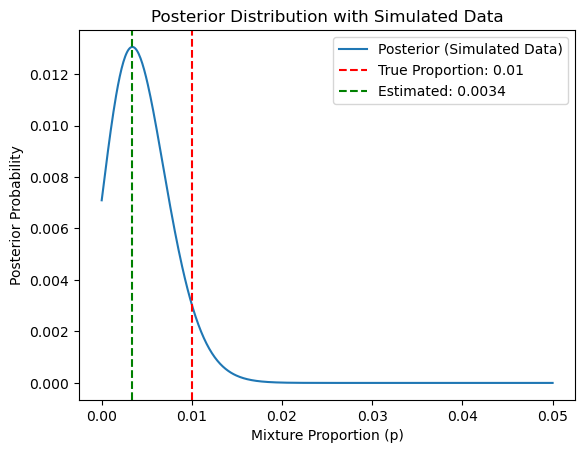

In [7]:
# Recompute the posterior with simulated data
posterior_values_simulated = [
    posterior(p, simulated_reads, total_reads, error_rate) for p in p_values
]

# Normalize the posterior
posterior_values_simulated /= np.sum(posterior_values_simulated)

# Estimate the mixture proportion (posterior mode)
p_estimated = p_values[np.argmax(posterior_values_simulated)]
print(f"Estimated Mixture Proportion: {p_estimated:.4f}")

# Plot the posterior for simulated data
plt.plot(p_values, posterior_values_simulated, label="Posterior (Simulated Data)")
plt.axvline(p_true, color='r', linestyle='--', label=f"True Proportion: {p_true}")
plt.axvline(p_estimated, color='g', linestyle='--', label=f"Estimated: {p_estimated:.4f}")
plt.xlabel("Mixture Proportion (p)")
plt.ylabel("Posterior Probability")
plt.legend()
plt.title("Posterior Distribution with Simulated Data")
plt.show()


In [11]:
def sensitivity_analysis(p_true_range, total_reads, eps):
    results = []
    for p_true in p_true_range:
        simulated_reads = simulate_reads(p_true, total_reads, eps)
        posterior_values = [
            posterior(p, simulated_reads, total_reads, eps) for p in p_values
        ]
        posterior_values /= np.sum(posterior_values)
        p_estimated = p_values[np.argmax(posterior_values)]
        results.append((p_true, p_estimated))
    return results

# Evaluate the method over a range of mixture proportions (0.001 to 0.02)
p_true_range = np.linspace(0.001, 0.02, 10)
results = sensitivity_analysis(p_true_range, total_reads, error_rate)

# Display the results
for p_true, p_estimated in results:
    print(f"True Proportion: {p_true:.4f}, Estimated: {p_estimated:.4f}")


True Proportion: 0.0010, Estimated: 0.0000
True Proportion: 0.0031, Estimated: 0.0059
True Proportion: 0.0052, Estimated: 0.0017
True Proportion: 0.0073, Estimated: 0.0059
True Proportion: 0.0094, Estimated: 0.0127
True Proportion: 0.0116, Estimated: 0.0153
True Proportion: 0.0137, Estimated: 0.0068
True Proportion: 0.0158, Estimated: 0.0170
True Proportion: 0.0179, Estimated: 0.0153
True Proportion: 0.0200, Estimated: 0.0076


In [21]:

# Define error rate
error_rate = 0.01

# Simulate reads for sample A (dominant variant)
def simulate_sample_A(total_reads, error_rate):
    # Assume the majority of reads in Sample A represent the A allele (1 - error rate)
    return np.random.binomial(total_reads, 1 - error_rate)

# Simulate reads for sample B (minor variant)
def simulate_sample_B(total_reads, error_rate):
    # Assume Sample B has B-specific variants, but with sequencing errors
    return np.random.binomial(total_reads, error_rate)

# Total reads at each informative position
total_reads = np.array([500, 400, 300])

# Simulate reads for Sample A and Sample B
reads_A = simulate_sample_A(total_reads, error_rate)
reads_B = simulate_sample_B(total_reads, error_rate)

print("Simulated Reads for Sample A (dominant variant):", reads_A)
print("Simulated Reads for Sample B (minor variant):", reads_B)


Simulated Reads for Sample A (dominant variant): [495 396 297]
Simulated Reads for Sample B (minor variant): [9 2 1]


In [22]:
# Function to simulate mixed reads from A and B for a given mixture proportion
def simulate_mixed_AB(p_true, total_reads, reads_A, reads_B):
    mixed_reads = []
    for reads_Ai, reads_Bi, n in zip(reads_A, reads_B, total_reads):
        # Sample A contributes (1 - p_true) proportion
        reads_from_A = np.random.binomial(n, 1 - p_true)
        # Sample B contributes p_true proportion
        reads_from_B = n - reads_from_A
        mixed_reads.append(reads_from_A + reads_from_B)
    return np.array(mixed_reads)

# Set the mixture proportion (e.g., 1% B)
p_true = 0.01

# Simulate mixed reads for Sample AB
reads_AB = simulate_mixed_AB(p_true, total_reads, reads_A, reads_B)

print("Simulated Mixed Reads for Sample AB (1% B):", reads_AB)


Simulated Mixed Reads for Sample AB (1% B): [500 400 300]


In [24]:
reads_AB

array([500, 400, 300])

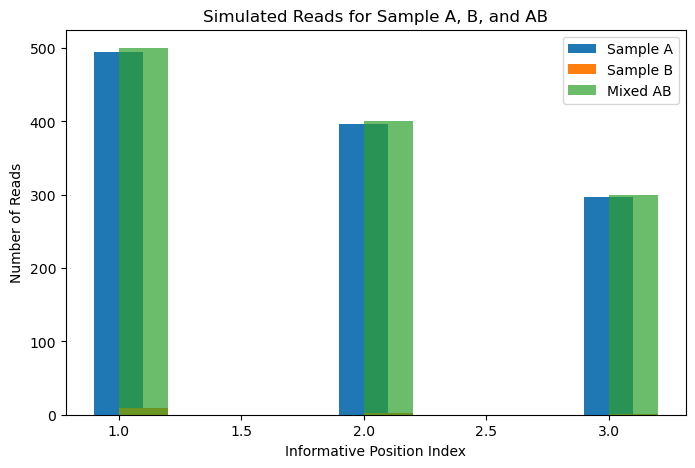

In [23]:
# Plot the simulated reads for Sample A, B, and AB
positions = range(1, len(total_reads) + 1)  # Informative position indices

plt.figure(figsize=(8, 5))

# Plot Sample A reads
plt.bar(positions, reads_A, width=0.2, label="Sample A", align='center')

# Plot Sample B reads
plt.bar(positions, reads_B, width=0.2, label="Sample B", align='edge')

# Plot Mixed Sample AB reads
plt.bar(positions, reads_AB, width=0.2, label="Mixed AB", align='edge', alpha=0.7)

plt.xlabel("Informative Position Index")
plt.ylabel("Number of Reads")
plt.title("Simulated Reads for Sample A, B, and AB")
plt.legend()
plt.show()
